In [104]:
import numpy as np
from mnist import MNIST
from sklearn.metrics.pairwise import euclidean_distances

In [2]:
mnist_loader = MNIST("../data/mnist/")
mnist_loader.gz = True

In [8]:
images, labels = mnist_loader.load_training()
# uncomment if test data needed
timages, tlabels = mnist_loader.load_testing()

In [9]:
images = np.array(images)
labels = np.array(labels)
timages = np.array(timages)
tlabels = np.array(tlabels)

In [14]:
images = np.concatenate((images, timages))
labels = np.concatenate((labels, tlabels))

In [15]:
images.shape#, timages.shape

(70000, 784)

In [16]:
n_rows = images.shape[0]
dims = images.shape[1]
#t_n_rows = timages.shape[0]

In [17]:
n_rows, dims

(70000, 784)

In [18]:
del timages, tlabels

# kmeans
## init

Randomly pick 10 images as starting points.

In [87]:
def init(k, seed):
    if seed != None:
        np.random.seed(seed)
    mu = np.empty((k, images.shape[1]))
    for rand in range(k):
        img_id = np.random.choice(n_rows)
        mu[rand] = images[img_id]
    return mu

`init_dist` takes into account the distances of different points when picking stating mu's.

In [88]:
def init_dist(k, seed):
    if seed != None:
        np.random.seed(seed)
    mu = np.empty((k, images.shape[1]))
    memmap = '../data/mnist/dist.memmap'
    fp = np.memmap(memmap, dtype='float32', shape=(n_rows, n_rows - 10000), mode='r')
    
    ids = []
    img_id = np.random.choice(n_rows)
    ids.append(img_id)
    mu[0] = images[img_id]
    for rand in range(1, k):
        distances = fp[img_id].copy()
        img_id = np.argmax(distances)
        while img_id in ids:
            distances[img_id] = -1
            img_id = np.argmax(distances)
        mu[rand] = images[img_id]
        ids.append(img_id)        
    del fp
    
    return mu

## E step
Assign memberships from current mu's. <br>
Also evaluate loss

In [89]:
def e_step(mu):
    distances = np.matrix(2(X=images, Y=mu))
    loss = np.sum(distances.min(axis=1))
    return np.array(distances.argmin(1).T).ravel(), loss

## M step
Calculate new mu's from current memberships

In [90]:
def m_step(pi, k):
    mu = np.empty((k, images.shape[1]))
    for cluster_id in range(k):
        cluster_images = images[np.where(pi == cluster_id)[0]]
        mu[cluster_id] = np.mean(cluster_images, axis=0)
    return mu

## external metrics

Helper function to get confusion matrix and cluster mappings for `k` and `pi`'s

In [374]:
def get_confusion_matrix(k, pi):
    conf_mat = [[0 for x in range(k)] for y in range(k)]
    for cluster_id in range(k):
        true_labels = labels[np.where(cluster_id == pi)]
        conf_mat[cluster_id] = np.bincount(true_labels)
    return np.array(conf_mat)

### Purity

In [394]:
def purity(confusion_matrix):
    Pj = confusion_matrix.max(axis=1)
    Mj = confusion_matrix.sum(axis=1)
    return sum(Pj)/sum(Mj)

### Gini

In [395]:
def gini(confusion_matrix):
    Mj = confusion_matrix.sum(axis=1, keepdims=True)
    gj = 1 - ((confusion_matrix/Mj)**2).sum(axis=1, keepdims=True)
    return (sum(gj*Mj)/sum(Mj))[0]

## k means helper

In [391]:
def kmeans(k, init_func, max_epochs, print_interval, seed):
    _loss, _purity, _gini = [], [], []
    _mu = init_func(k, seed)
    for _epoch in range(max_epochs):
        # e step
        _pi, loss = e_step(_mu)
        # m step
        mu = m_step(_pi, k)
        
        # evaluation
        conf_mat = get_confusion_matrix(k, _pi)
        p = purity(conf_mat)
        g = gini(conf_mat)
        
        # append to global
        _purity.append(p)
        _gini.append(g)
        _loss.append(loss)
        
        # print info
        if _epoch % print_interval == 0:
            print('\tEpoch:', _epoch, 'Loss:', loss, 
                  'Purity:', p, 'Gini Index:', g)
                
        # check for convergence
        if np.allclose(_mu, mu):
            print('\tConvergence at epoch {0}, Loss at {1}'.format(_epoch, loss))
            break
        _mu = mu
        if _epoch == (max_epochs - 1):
            print('\tNo convergence after {0} epochs, try higher value. Loss at {1}'.format(max_epochs, loss))
            
    return _loss, _purity, _gini

## graph helpers

In [392]:
def graph_helper_loss(loss):
    plt.plot(range(len(loss)), np.log(loss), label = 'k = {0}'.format(k))
    plt.xlabel('Epochs')
    plt.ylabel('Loss (log_10)')
    plt.title('Loss vs Epochs')
    plt.legend()
    plt.show()

In [403]:
def graph_helper_metrics(purity, gini):
    plt.plot(range(len(gini)), gini, 'r', label = 'Gini Index')
    plt.plot(range(len(purity)), purity, 'g', label = 'Purity')
    plt.xlabel('Epochs')
    plt.ylabel('Gini Index/Purity')
    plt.title('Gini Index/Purity vs Epochs')
    plt.legend()
    plt.show()

## All together

In [411]:
def do_kmeans(ks):
    seed = np.random.randint(n_rows)
    
    for k in ks:
        print('For k = {0}:'.format(k))
        t_loss, t_purity, t_gini = kmeans(k=k, init_func=init, 
                                          max_epochs=100, 
                                          print_interval=10, 
                                          seed=seed)
        
        print('\n\tFinal values: \n\t\tLoss: {0}'.format(t_loss[-1]))
        print('\t\tPurity: {0}'.format(t_purity[-1]))
        print('\t\tGini Index: {0}\n'.format(t_gini[-1]))
        
        graph_helper_loss(t_loss)
        graph_helper_metrics(t_purity, t_gini)

For k = 5:
	Epoch: 0 Loss: 160751746.01 Purity: 0.277628571429 Gini Index: 0.821005945576
	No convergence after 5 epochs, try higher value. Loss at 117077548.2647222

	Final values: 
		Loss: 117077548.2647222
		Purity: 0.41294285714285717
		Gini Index: 0.7133372979431899



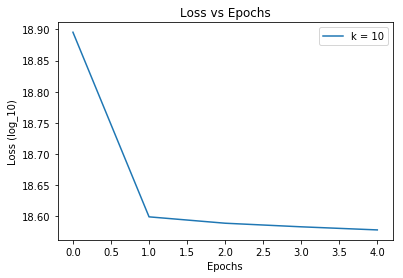

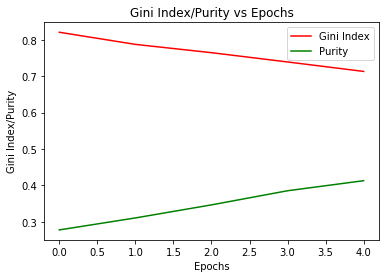

For k = 10:
	Epoch: 0 Loss: 147407367.697 Purity: 0.372271428571 Gini Index: 0.75222968593
	No convergence after 5 epochs, try higher value. Loss at 111439340.4020106

	Final values: 
		Loss: 111439340.4020106
		Purity: 0.4876714285714286
		Gini Index: 0.6322275253872125



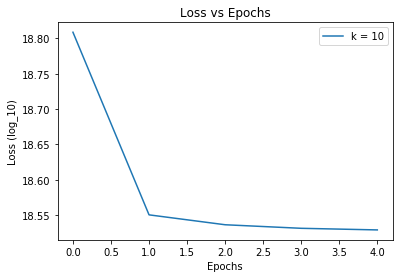

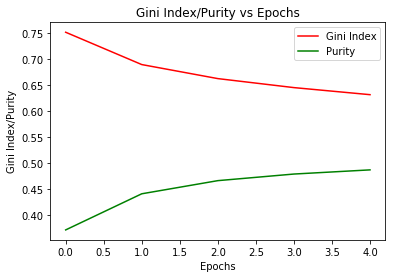

In [412]:
do_kmeans([10, 5, 20])